# Workflow

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import sys

sys.path.append('../hydra_tod/')


In [2]:
import pickle
from simulation import MultiTODSimulation
# Load the simulation data from a pickle file
with open('multi_tod_simulation_data.pkl', 'rb') as f:
    multi_tod_sim = pickle.load(f)

In [3]:
# Make all the individual variables available for backward compatibility
t_list = multi_tod_sim.t_list
theta_c_setting = multi_tod_sim.theta_c_setting
phi_c_setting = multi_tod_sim.phi_c_setting
theta_c_rising = multi_tod_sim.theta_c_rising
phi_c_rising = multi_tod_sim.phi_c_rising
bool_map_setting = multi_tod_sim.bool_map_setting
bool_map_rising = multi_tod_sim.bool_map_rising
integrated_beam_setting = multi_tod_sim.integrated_beam_setting
integrated_beam_rising = multi_tod_sim.integrated_beam_rising
full_bool_map = multi_tod_sim.full_bool_map
pixel_indices = multi_tod_sim.pixel_indices
integrated_beam = multi_tod_sim.integrated_beam
Tsky_operator_setting = multi_tod_sim.Tsky_operator_setting
Tsky_operator_rising = multi_tod_sim.Tsky_operator_rising
sky_params = multi_tod_sim.sky_params
ntime = multi_tod_sim.ntime
ndiode_proj = multi_tod_sim.ndiode_proj
nd_rec_operator = multi_tod_sim.nd_rec_operator
nd_rec_params = multi_tod_sim.nd_rec_params
gain_proj = multi_tod_sim.gain_proj
gain_params_setting = multi_tod_sim.gain_params_setting
gain_params_rising = multi_tod_sim.gain_params_rising
gains_setting = multi_tod_sim.gains_setting
gains_rising = multi_tod_sim.gains_rising
fc = multi_tod_sim.fc
logfc = multi_tod_sim.logfc
f0 = multi_tod_sim.f0
logf0 = multi_tod_sim.logf0
noise_setting = multi_tod_sim.noise_setting
noise_rising = multi_tod_sim.noise_rising
Tsys_setting = multi_tod_sim.Tsys_setting
Tsys_rising = multi_tod_sim.Tsys_rising
TOD_setting = multi_tod_sim.TOD_setting
TOD_rising = multi_tod_sim.TOD_rising
pixels_c_setting = multi_tod_sim.pixels_c_setting
bool_map_c_setting = multi_tod_sim.bool_map_c_setting
calibration_1_index = multi_tod_sim.calibration_1_index
calibration_5_indices = multi_tod_sim.calibration_5_indices

# Additional constants from the original code
T_ndiode = multi_tod_sim.T_ndiode
rec_params = multi_tod_sim.rec_params
dtime = multi_tod_sim.dtime
alpha = multi_tod_sim.alpha
logf0_list = [multi_tod_sim.logf0]
sigma_2 = multi_tod_sim.sigma_2

In [4]:
init_Tsys_params = np.hstack([sky_params, nd_rec_params, nd_rec_params])
init_noise_params = [logf0, alpha]


init_Tloc_params_list = [nd_rec_params, nd_rec_params]
init_Tsky_params = sky_params
init_noise_params_list = [init_noise_params, init_noise_params]

prior_std_frac = 0.1

# gain_prior_mean = gain_params_setting
# gain_prior_cov_inv = 1.0 / (prior_std_frac * gain_params_setting)**2  # Prior STD ~10%
# gain_prior_cov_inv[gain_prior_cov_inv > 100] = 100

Tsky_prior_cov_inv = 1. / (prior_std_frac * sky_params)**2
calibration_indices = calibration_5_indices
Tsky_prior_cov_inv[calibration_indices] = 1e20

aux = 1.0 / (nd_rec_params)**2  # Prior STD ~100%
aux[0] = 1.0
aux[1] = 1.0
Trec_prior_cov_inv_list = [aux, aux]

def log_prior_noise(params):
    _, alpha_est = params
    return -1e10 * (alpha_est - alpha)**4 

In [5]:
gain_prior_mean_setting = gain_params_setting
gain_prior_mean_rising = gain_params_rising

gain_prior_cov_inv_setting = 1.0 / (prior_std_frac * gain_params_setting)**2  # Prior STD ~10%
gain_prior_cov_inv_setting[gain_prior_cov_inv_setting > 100] = 100
gain_prior_cov_inv_rising = 1.0 / (prior_std_frac * gain_params_rising)**2  # Prior STD ~10%
gain_prior_cov_inv_rising[gain_prior_cov_inv_rising > 100] = 100

In [ ]:
# Import the FlickerCorrEmulator class first
from full_Gibbs_sampler import TOD_Gibbs_sampler

Tsys_samples, all_gain_samples, all_noise_samples = \
    TOD_Gibbs_sampler(
        [TOD_setting, TOD_rising],
        [t_list, t_list],
        [gain_proj, gain_proj],
        [Tsky_operator_setting, Tsky_operator_rising],
        [nd_rec_operator, nd_rec_operator],
        init_Tsky_params,
        init_Tloc_params_list,
        init_noise_params_list,
        [logfc, logfc],
        wnoise_var=2.5e-6,
        Tsky_prior_cov_inv=Tsky_prior_cov_inv,
        Tsky_prior_mean=sky_params,
        local_Tloc_prior_cov_inv_list=Trec_prior_cov_inv_list,
        local_Tloc_prior_mean_list=[nd_rec_params, nd_rec_params],
        local_gain_prior_cov_inv_list=[gain_prior_cov_inv_setting, gain_prior_cov_inv_rising],
        local_gain_prior_mean_list=[gain_prior_mean_setting, gain_prior_mean_rising],
        local_noise_prior_func_list=[log_prior_noise, log_prior_noise],
        joint_Tsys_sampling=True,
        smooth_gain_model="linear",
        noise_sampler_type="emcee",
        noise_Jeffreys_prior=False,
        n_samples=2000,
        tol=1e-20)

In [ ]:
# First, save the samples as npy files..

np.save("outputs/GSF5_db/Tsys_samples_linearG.npy", Tsys_samples)
np.save("outputs/GSF5_db/gain_samples_linearG.npy", np.concatenate(all_gain_samples, axis=0))
np.save("outputs/GSF5_db/noise_samples_linearG.npy", np.concatenate(all_noise_samples, axis=0))

# np.save("outputs/GSF5_db/Tsys_samples_log2.npy", Tsys_samples)
# np.save("outputs/GSF5_db/gain_samples_log2.npy", np.concatenate(all_gain_samples, axis=0))
# np.save("outputs/GSF5_db/noise_samples_log2.npy", np.concatenate(all_noise_samples, axis=0))



In [6]:
Tsys_samples = np.load("outputs/GSF5_db/Tsys_samples_linearG.npy")
gain_samples = np.load("outputs/GSF5_db/gain_samples_linearG.npy")
noise_samples = np.load("outputs/GSF5_db/noise_samples_linearG.npy")


In [7]:
from MCMC_diagnostics import diagnostics

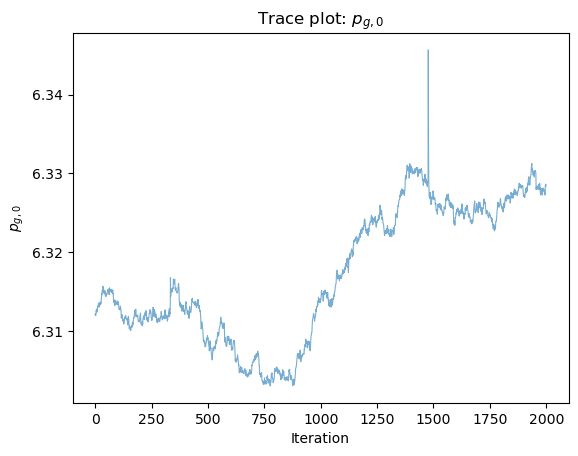

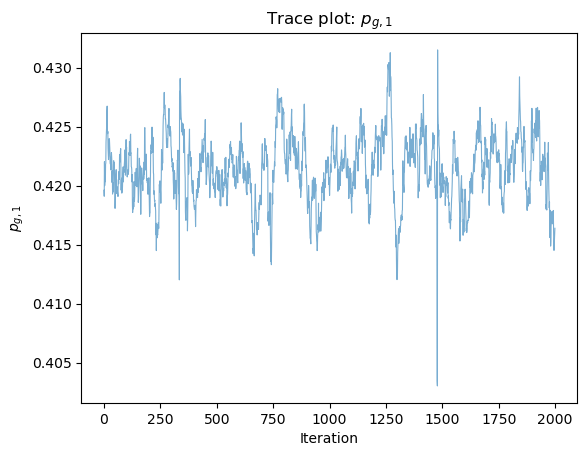

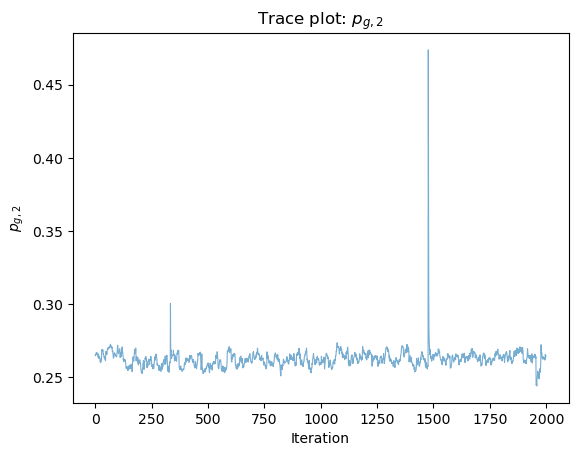

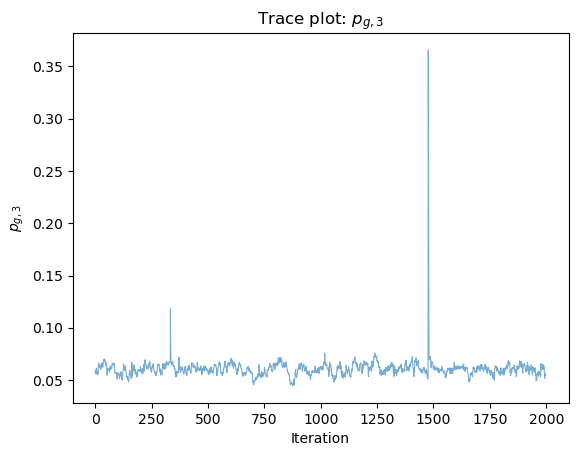

{'$p_{g,0}$': {'ESS_min': 2.9489959308351184,
  'ESS_median': 2.9489959308351184,
  'Rhat_split': 2.853577918684163},
 '$p_{g,1}$': {'ESS_min': 90.56772340687988,
  'ESS_median': 90.56772340687988,
  'Rhat_split': 1.010112316399931},
 '$p_{g,2}$': {'ESS_min': 227.3942102148299,
  'ESS_median': 227.3942102148299,
  'Rhat_split': 1.0236783840466088},
 '$p_{g,3}$': {'ESS_min': 284.51653795537067,
  'ESS_median': 284.51653795537067,
  'Rhat_split': 1.003943812801458}}

In [6]:
aux = gain_samples[0].reshape(1, 2000, 4)
diagnostics(aux, param_names=[r"$p_{g,0}$", r"$p_{g,1}$",r"$p_{g,2}$",r"$p_{g,3}$"], max_plots=5)

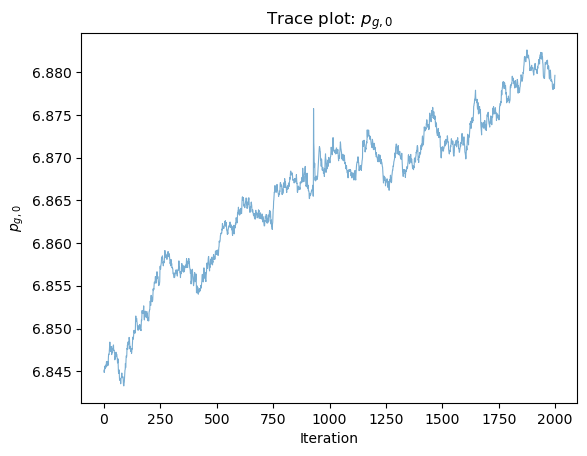

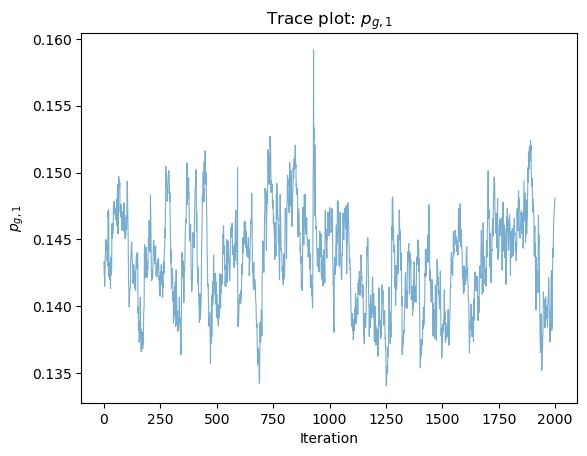

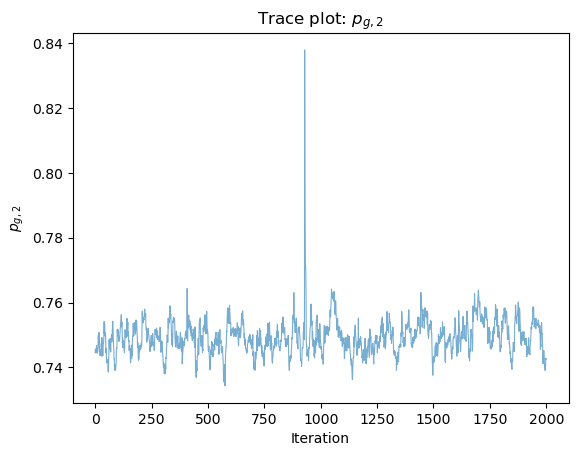

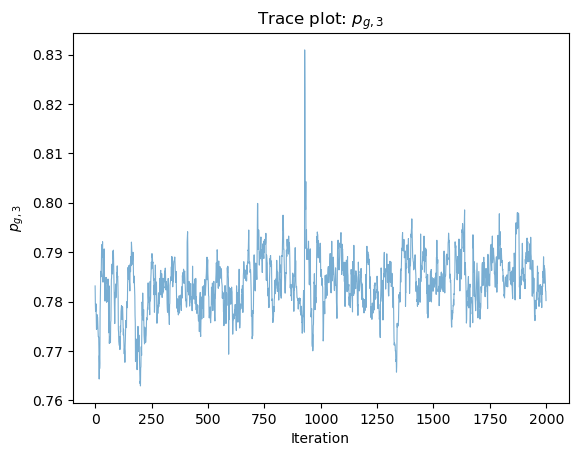

{'$p_{g,0}$': {'ESS_min': 3.05672269393911,
  'ESS_median': 3.05672269393911,
  'Rhat_split': 1.9961897715053685},
 '$p_{g,1}$': {'ESS_min': 28.834089058235417,
  'ESS_median': 28.834089058235417,
  'Rhat_split': 1.055687125923466},
 '$p_{g,2}$': {'ESS_min': 142.59853749852647,
  'ESS_median': 142.59853749852647,
  'Rhat_split': 1.0163293320238087},
 '$p_{g,3}$': {'ESS_min': 116.54898986475894,
  'ESS_median': 116.54898986475894,
  'Rhat_split': 1.046500300106304}}

In [7]:
aux = gain_samples[1].reshape(1, 2000, 4)
diagnostics(aux, param_names=[r"$p_{g,0}$", r"$p_{g,1}$",r"$p_{g,2}$",r"$p_{g,3}$"], max_plots=5)

292
All pixels - Mean: -0.0103, Std: 0.2533, RMS: 0.2535
All pixels - 16th-84th percentile: [-0.0393, 0.0708]
Internal pixels - Mean: -0.0010, Std: 0.1688, RMS: 0.1688
Internal pixels - 16th-84th percentile: [-0.0206, 0.0274]
Plot saved to: figures/new/GSF5_db_mean_res.pdf


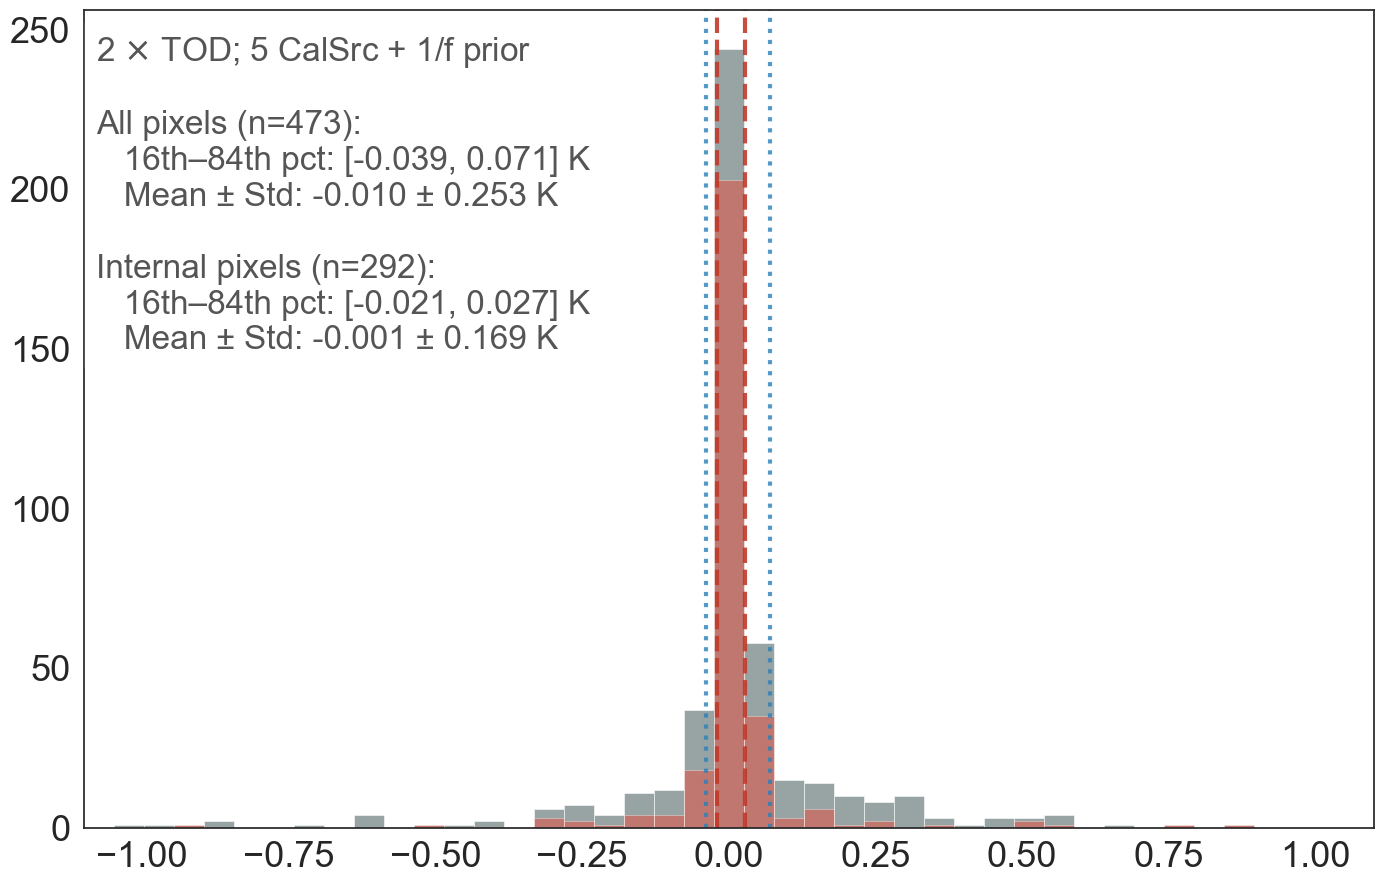

All pixels - Mean: -0.0106, Std: 0.2544, RMS: 0.2546
All pixels - 16th-84th percentile: [-0.0378, 0.0736]
Internal pixels - Mean: -0.0009, Std: 0.1683, RMS: 0.1683
Internal pixels - 16th-84th percentile: [-0.0199, 0.0273]
Plot saved to: figures/new/GSF5_db_median_res.pdf


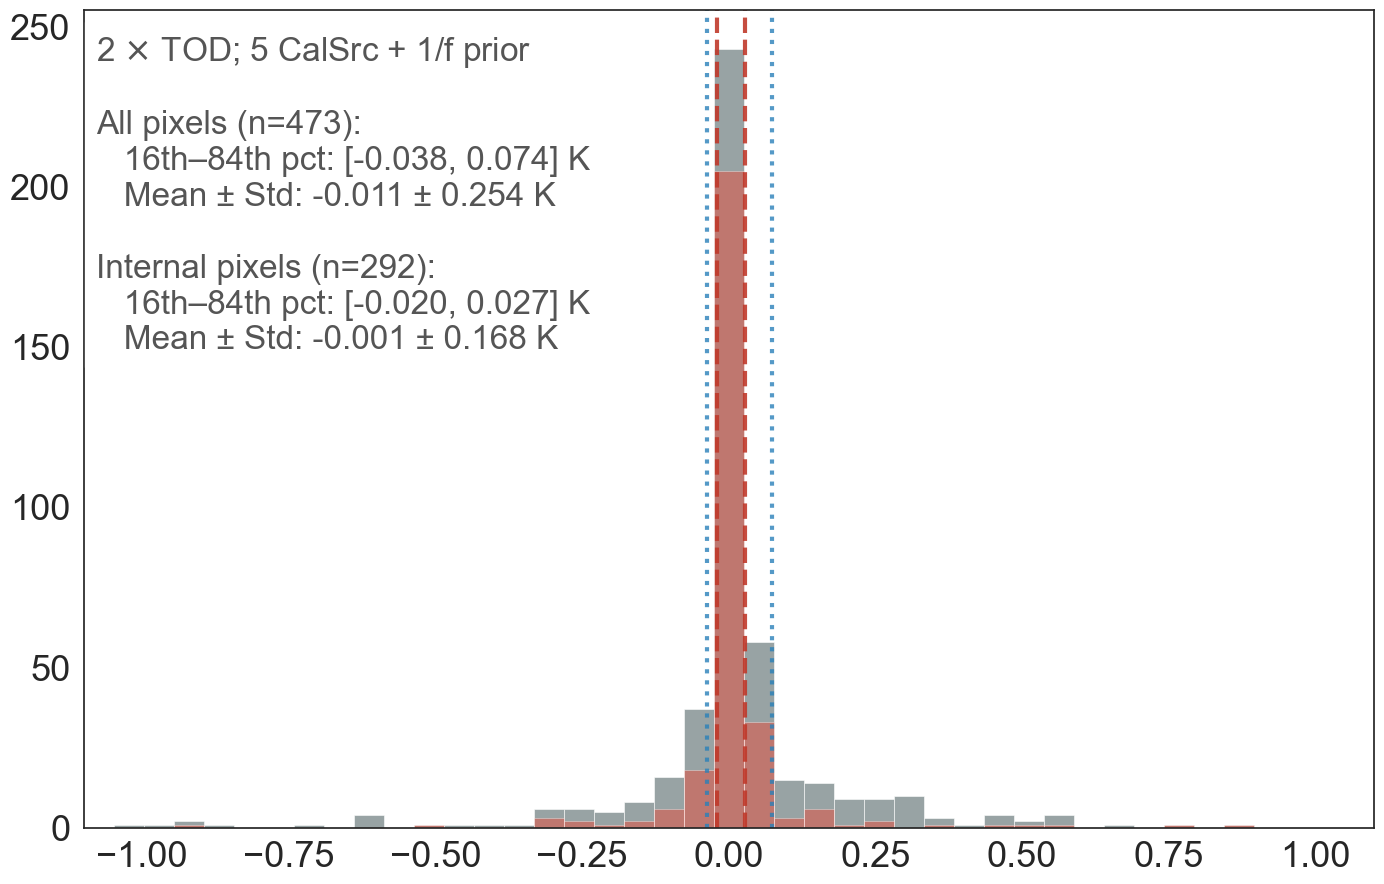

/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be in

{'mean': (array([ 8.6416028 ,  8.57585441,  8.64341921,  8.34933917,  8.09880947,
          7.96824236,  7.6241589 ,  7.28094006,  7.81034258,  6.90151736,
          8.56586511,  8.26813375,  8.99625966,  8.48958207,  9.12904596,
          8.12765004,  7.66017095,  8.79348275,  8.64885897,  7.92501317,
          8.30979092,  7.94059871,  8.73242473,  7.2125075 ,  7.30315797,
          7.08775712,  6.61815342,  7.57669893,  6.13268728,  6.04573951,
          6.23247791,  5.89202028,  4.91632176,  5.62679287,  5.53974334,
          5.68492282,  5.73225513,  8.62873101,  8.84943781,  8.70710315,
          8.5741758 ,  8.36585518,  9.03297626,  8.14477478,  7.87954664,
          7.8506206 ,  7.78974745,  8.06633498,  7.86111669,  7.62458322,
          6.91200072,  6.73162896,  7.00229269,  6.77626758,  6.45840483,
          6.22848892,  6.180443  ,  6.09177271,  5.6583299 ,  5.84241899,
          5.54329214,  5.73653413,  6.06133003,  5.99590308,  8.60376569,
          9.25189127,  8.83140

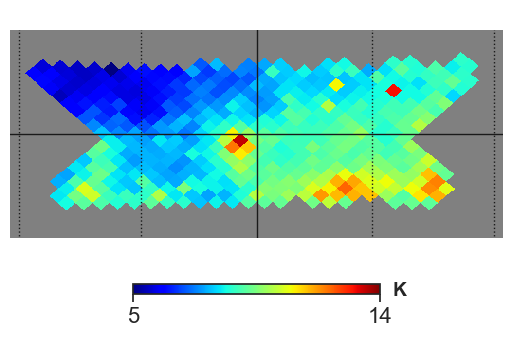

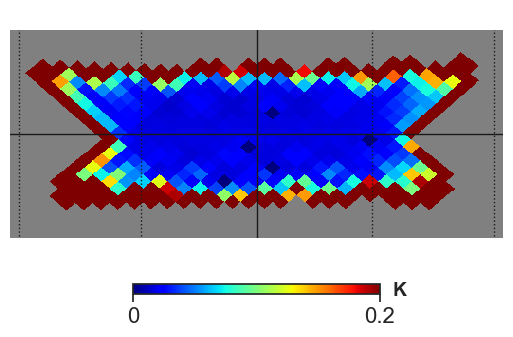

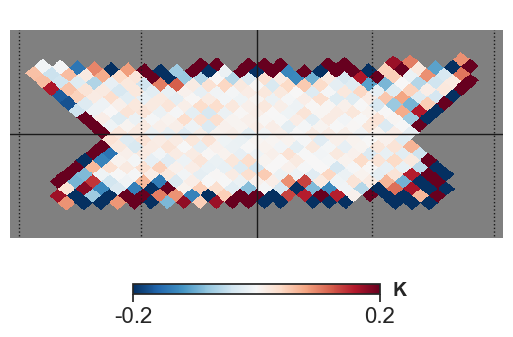

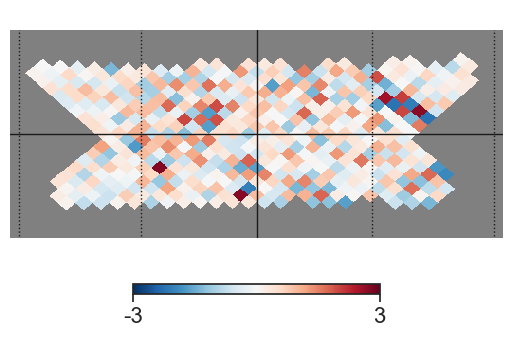

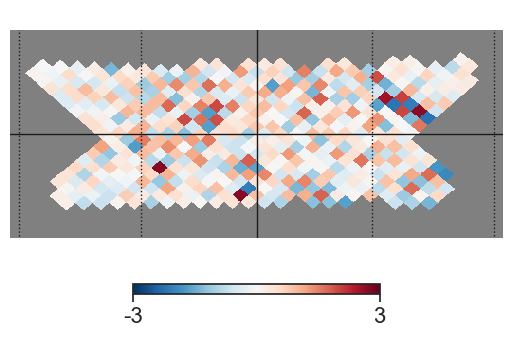

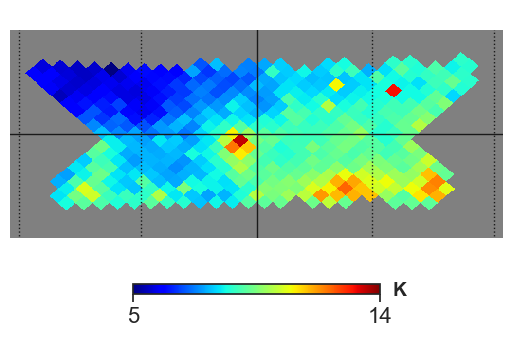

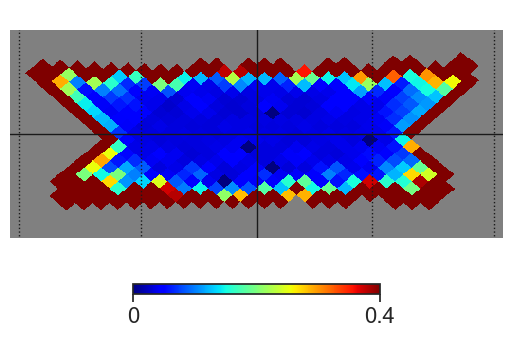

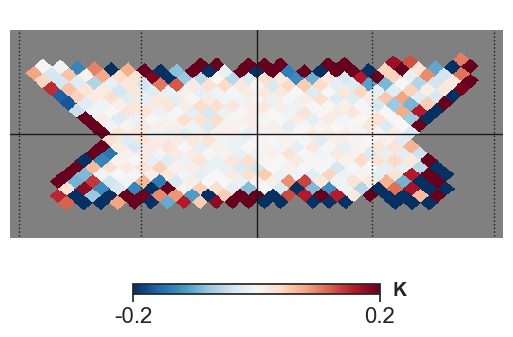

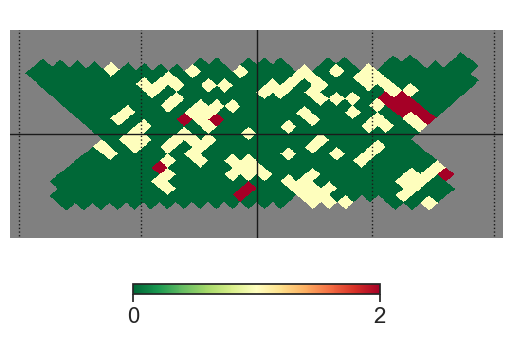

In [8]:
from simulation import TODSimulation, MultiTODSimulation

from analysis import explore_posterior_joint_Tsys

explore_posterior_joint_Tsys(Tsys_samples, 
                             gain_samples, 
                             noise_samples, 
                             sky_params,
                             title_str= r'2 $\times$ TOD; 5 CalSrc + 1/f prior',
                             save_path='figures/new/GSF5_db',
                             two_x_TODs=True, 
                             warm_up=0, 
                             cbar=True
                             )

All pixels - Mean: -0.0102, Std: 0.2568, RMS: 0.2570
All pixels - 16th-84th percentile: [-0.0388, 0.0797]
Internal pixels - Mean: -0.0003, Std: 0.1703, RMS: 0.1703
Internal pixels - 16th-84th percentile: [-0.0198, 0.0286]
Plot saved to: figures/new/GSF5_db_forth_mean_res.pdf


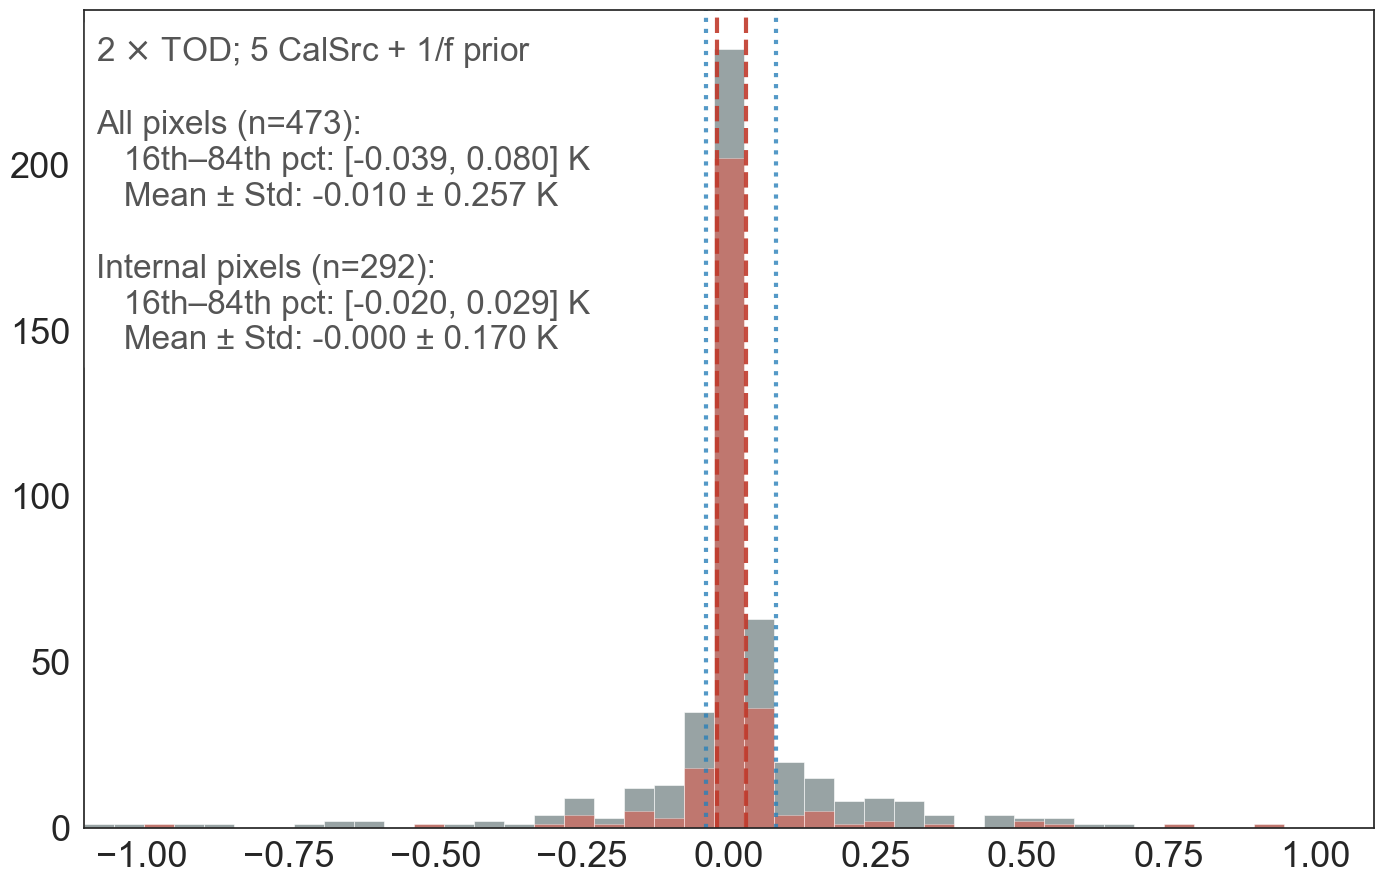

All pixels - Mean: -0.0110, Std: 0.2582, RMS: 0.2585
All pixels - 16th-84th percentile: [-0.0363, 0.0722]
Internal pixels - Mean: 0.0001, Std: 0.1693, RMS: 0.1693
Internal pixels - 16th-84th percentile: [-0.0203, 0.0285]
Plot saved to: figures/new/GSF5_db_forth_median_res.pdf


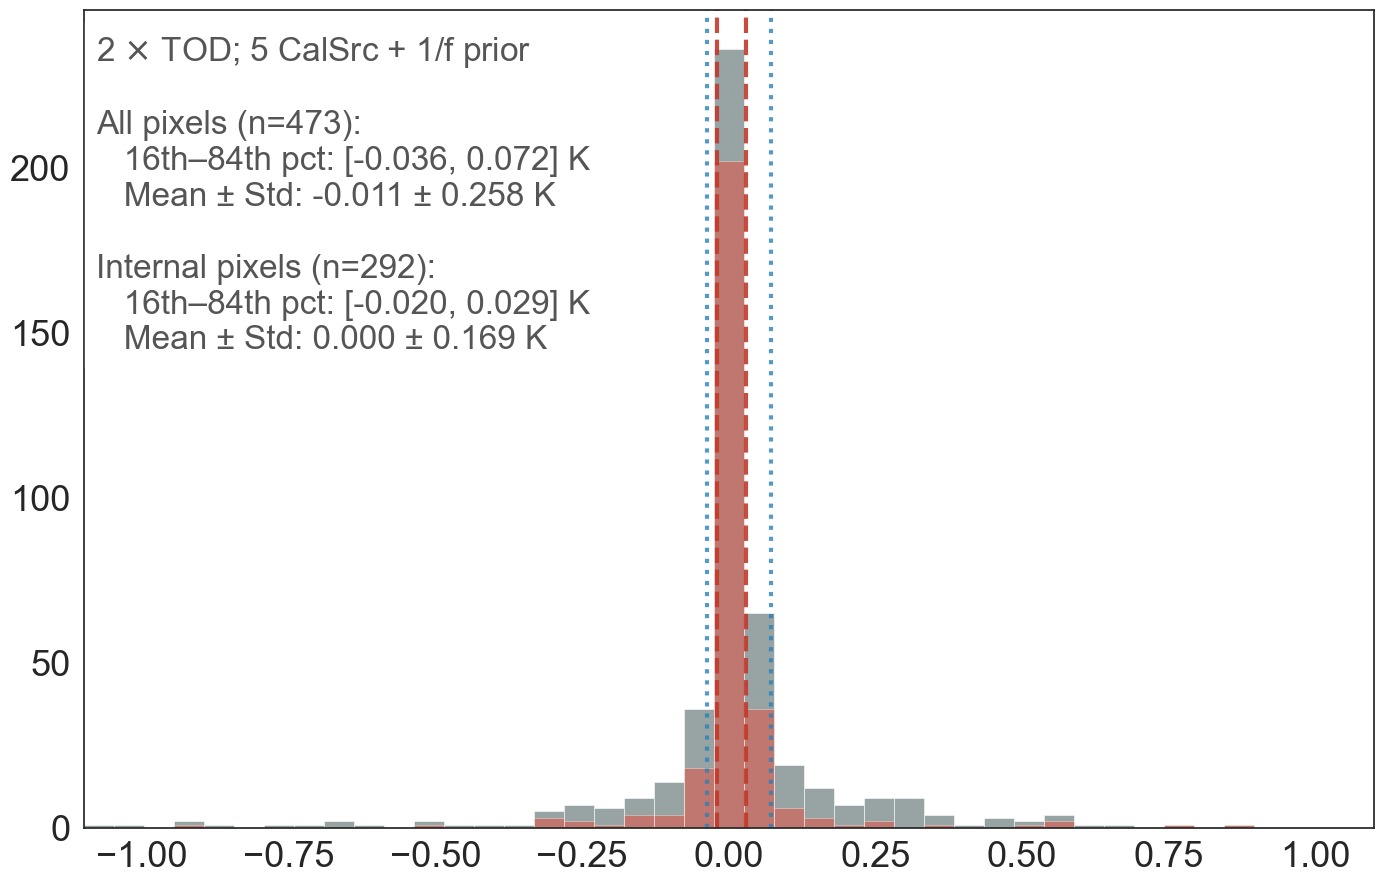

/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be in

{'mean': (array([ 8.63418289,  8.58525924,  8.62266705,  8.33462033,  8.10946485,
          7.98936201,  7.61932584,  7.22510598,  7.8192667 ,  6.87423408,
          8.55953684,  8.23148942,  9.02112782,  8.50599731,  9.10814567,
          8.17226426,  7.65589093,  8.80384068,  8.67906957,  7.93559409,
          8.31229835,  7.93904026,  8.75919141,  7.24306896,  7.3084618 ,
          7.08785413,  6.61223441,  7.56055002,  6.1252583 ,  6.05868428,
          6.24873779,  5.89863514,  4.92536301,  5.60828037,  5.53275765,
          5.67613692,  5.7264555 ,  8.63851791,  8.83069651,  8.70212627,
          8.57701125,  8.35903442,  9.04184092,  8.15744352,  7.87892206,
          7.84891791,  7.78896152,  8.06236845,  7.8606762 ,  7.62361457,
          6.91287065,  6.7255834 ,  7.00550909,  6.78121117,  6.4570749 ,
          6.24570446,  6.18761585,  6.09763052,  5.66544826,  5.85793042,
          5.56734467,  5.74766003,  6.06571886,  5.97871344,  8.58919736,
          9.2607104 ,  8.83456

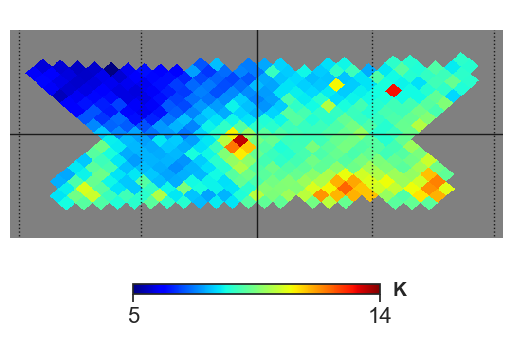

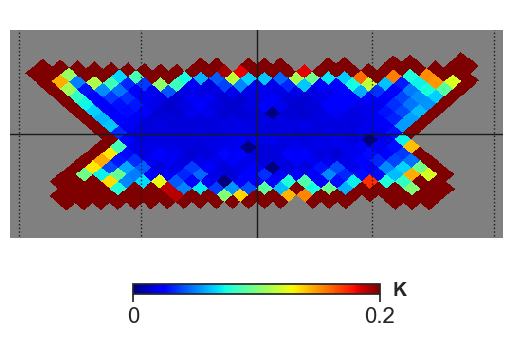

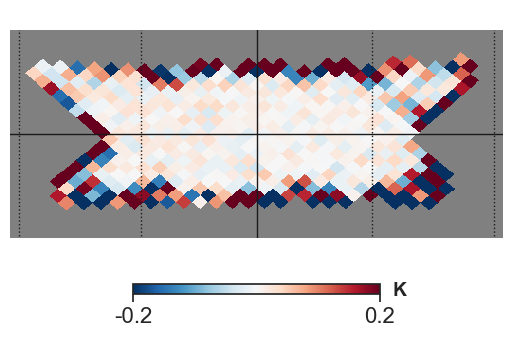

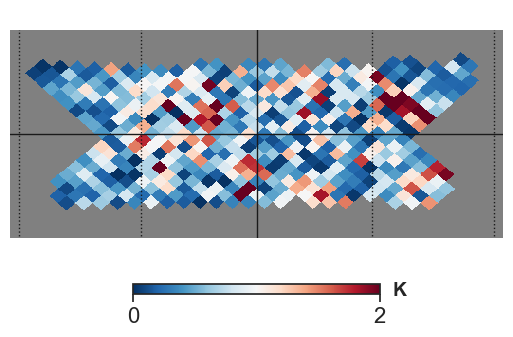

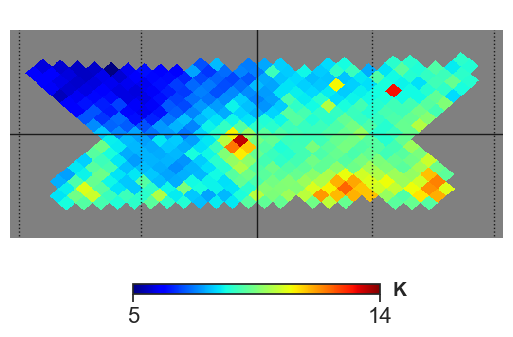

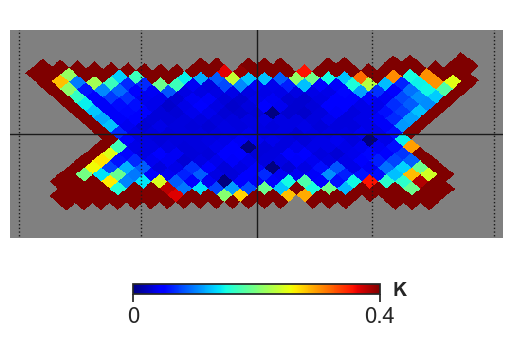

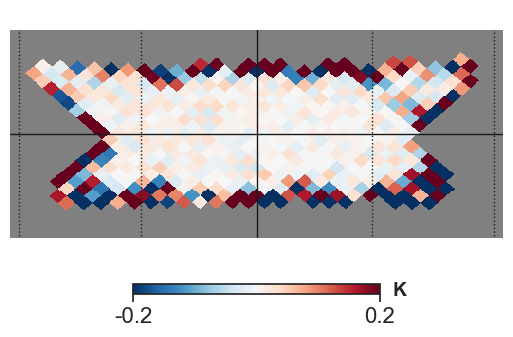

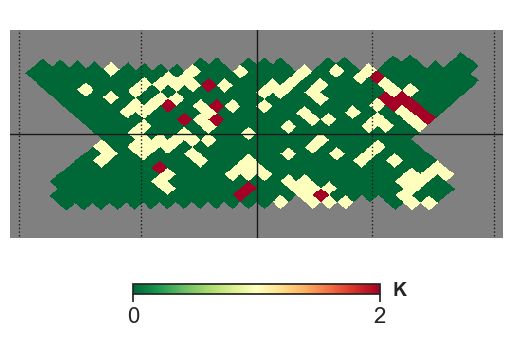

In [18]:
start_ind=1500
end_ind=2000
explore_posterior_joint_Tsys(Tsys_samples[start_ind:end_ind, :], 
                             gain_samples[:,start_ind:end_ind, :], 
                             noise_samples[:,start_ind:end_ind, :], 
                             sky_params,
                             title_str= r'2 $\times$ TOD; 5 CalSrc + 1/f prior',
                             save_path='figures/new/GSF5_db_forth',
                             two_x_TODs=True, 
                             warm_up=0, 
                             cbar=True
                             )